In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
main_df = pd.read_csv('jte240_data/jte240_history_with_features')

In [19]:
#dropping all non-numeric + irrelevant columns
final_df = main_df.T.apply(pd.to_numeric, errors='coerce').dropna().T.\
    drop(columns=['msPlayed', 'time_signature', 'mode', 'duration_ms', 'key'])
final_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.519,0.900,-4.844,0.0490,0.01260,0.000055,0.1030,0.594,120.001
1,0.312,0.614,-6.073,0.0466,0.05890,0.000000,0.0898,0.356,205.379
2,0.736,0.593,-8.405,0.0378,0.01510,0.000001,0.0562,0.612,121.996
3,0.774,0.750,-4.927,0.0412,0.00207,0.000018,0.0808,0.927,118.015
4,0.383,0.836,-6.086,0.0389,0.03870,0.000107,0.1180,0.469,107.030
...,...,...,...,...,...,...,...,...,...
16976,0.792,0.625,-5.609,0.0536,0.00776,0.001800,0.3290,0.370,103.967
16977,0.501,0.933,-3.476,0.1980,0.04570,0.000000,0.3760,0.708,170.130
16978,0.497,0.923,-4.512,0.1380,0.00282,0.000000,0.1580,0.663,181.074
16979,0.882,0.662,-6.382,0.2420,0.01240,0.000000,0.1060,0.570,120.034


In [20]:
#normalizing loudness and tempo
final_df['loudness'] = final_df.loudness.apply(lambda x: x/final_df['loudness'].max())
final_df['tempo'] = final_df.tempo.apply(lambda x: x/final_df['tempo'].max())
final_df = final_df.drop_duplicates()
final_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.519,0.900,9.369439,0.0490,0.01260,0.000055,0.1030,0.594,0.553117
1,0.312,0.614,11.746615,0.0466,0.05890,0.000000,0.0898,0.356,0.946648
2,0.736,0.593,16.257253,0.0378,0.01510,0.000001,0.0562,0.612,0.562313
3,0.774,0.750,9.529981,0.0412,0.00207,0.000018,0.0808,0.927,0.543963
4,0.383,0.836,11.771760,0.0389,0.03870,0.000107,0.1180,0.469,0.493330
...,...,...,...,...,...,...,...,...,...
16974,0.488,0.967,5.224371,0.0755,0.01470,0.000000,0.1090,0.341,0.603483
16975,0.492,0.932,4.644101,0.2030,0.00711,0.000000,0.1770,0.635,0.696765
16977,0.501,0.933,6.723404,0.1980,0.04570,0.000000,0.3760,0.708,0.784175
16978,0.497,0.923,8.727273,0.1380,0.00282,0.000000,0.1580,0.663,0.834619


## Spectral Clustering

Spectral Clustering is a clustering method which computes a 'similarity graph' from the datapoints and utilizes that graph in a clustering algorithm. Like with KMeans, we are required to state a predetermined number of clusters. Hence, we use the Elbow Method with KMeans to determine the optimal amount of clusters, and apply Spectral Clustering using that.

In [21]:
from sklearn.cluster import SpectralClustering, KMeans

In [22]:
#Using Elbow Method
inertias = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(final_df)
    inertias.append(kmeans.inertia_)

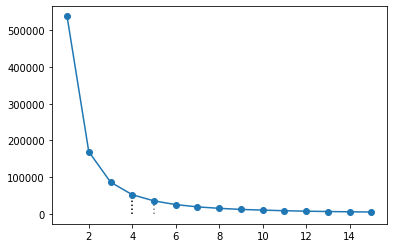

In [76]:
plt.plot(range(1,16), inertias, 'o-')
plt.vlines(4, ymin=0, ymax=inertias[3], ls=':', colors='black')
plt.vlines(5, ymin=0, ymax=inertias[4], ls=':', colors='grey')
plt.show()

As we can see, the optimal amount of clusters is either 4 or 5; we can use four for this and compare with five in the `Analysis` section

In [24]:
spectral = SpectralClustering(n_clusters=4)

In [26]:
spectral_labels = spectral.fit_predict(final_df)

Let's see the distribution of the four clusters and conduct some PCA using both 2D and 3D graphs

In [28]:
pd.DataFrame({'labels':spectral_labels, 'count':spectral_labels}).groupby('labels').count()

,count
labels,
0,3660
1,2
2,11
3,130


In [29]:
from sklearn.decomposition import PCA
pca2d = PCA(n_components = 2)
pca3d = PCA(n_components = 3)

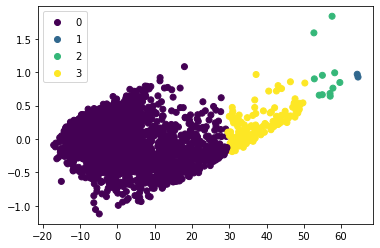

In [151]:
pca_2d = pd.DataFrame(pca2d.fit_transform(final_df))
pca_2d['labels'] = spectral_labels
pca_2d.columns = ['x','y','labels']
pca2d_scatter = plt.scatter(pca_2d['x'], pca_2d['y'], c=pca_2d['labels']);
plt.legend(*pca2d_scatter.legend_elements());

In [36]:
from mpl_toolkits import mplot3d

pca_3d = pd.DataFrame(pca3d.fit_transform(final_df))
pca_3d['labels'] = spectral_labels
pca_3d.columns = ['x','y','z','labels']

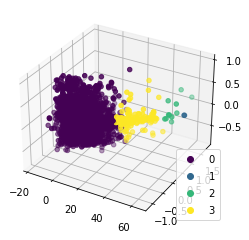

In [159]:
ax = plt.axes(projection='3d')
pca_3ds = ax.scatter3D(pca_3d['x'], pca_3d['y'], pca_3d['z'], c=pca_3d['labels']);
plt.legend(*pca_3ds.legend_elements(), loc="lower right");

## Affinity Propagation

While we need to know the amount of clusters beforehand for `Spectral Clustering`, the `Affinity Propagation` model does that for us. It chooses centroids, and sends 'messages' between pairs of samples until a convergence condition is met. 
Affinity Propagation works best on datasets that have distinct clusters since a convergence condition can be met. If the data is more densely defined, a convergence condition may not be met (and it might be better to use `Mean Shift` in that instance)

In [40]:
from sklearn.cluster import AffinityPropagation

In [42]:
#We can use the default parameters for this class
affinity = AffinityPropagation()
affinity_labels = affinity.fit_predict(final_df)

/Users/rnnair/opt/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


The convergence warning shows that a convergence condition was not met, meaning everything was shown to be in one cluster. Let's graph the set using PCA anyway

In [43]:
pca_2da = pd.DataFrame(pca2d.fit_transform(final_df))
pca_2da['labels'] = affinity_labels
pca_2da.columns = ['x','y','labels']

pca_3da = pd.DataFrame(pca3d.fit_transform(final_df))
pca_3da['labels'] = affinity_labels
pca_3da.columns = ['x','y','z','labels']

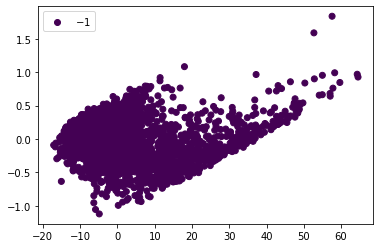

In [152]:
aff_scatter = plt.scatter(pca_2da['x'], pca_2da['y'], c=pca_2da['labels'])
plt.legend(*aff_scatter.legend_elements());
plt.show()

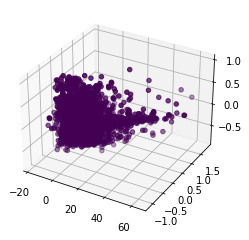

In [45]:
ax = plt.axes(projection='3d')
ax.scatter3D(pca_3da['x'], pca_3da['y'], pca_3da['z'], c=pca_3da['labels']);

## Further Analysis and Data Visualization

This is for Spectral Clustering only as Affinity Propagation did not yield any clusters.
With the clusters decided, it would be beneficial to see how similar the features for each class are, especially given the lopsided nature. 

In [108]:
#getting old df without normalized quantities
analysis = main_df.T.apply(pd.to_numeric, errors='coerce').dropna().T.\
    drop(columns=['msPlayed', 'time_signature', 'mode', 'duration_ms', 'key']).drop_duplicates()
analysis['label'] = spectral_labels
analysis

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,label
0,0.519,0.900,-4.844,0.0490,0.01260,0.000055,0.1030,0.594,120.001,0
1,0.312,0.614,-6.073,0.0466,0.05890,0.000000,0.0898,0.356,205.379,0
2,0.736,0.593,-8.405,0.0378,0.01510,0.000001,0.0562,0.612,121.996,0
3,0.774,0.750,-4.927,0.0412,0.00207,0.000018,0.0808,0.927,118.015,0
4,0.383,0.836,-6.086,0.0389,0.03870,0.000107,0.1180,0.469,107.030,0
...,...,...,...,...,...,...,...,...,...,...
16974,0.488,0.967,-2.701,0.0755,0.01470,0.000000,0.1090,0.341,130.928,0
16975,0.492,0.932,-2.401,0.2030,0.00711,0.000000,0.1770,0.635,151.166,0
16977,0.501,0.933,-3.476,0.1980,0.04570,0.000000,0.3760,0.708,170.130,0
16978,0.497,0.923,-4.512,0.1380,0.00282,0.000000,0.1580,0.663,181.074,0


In [109]:
analysis = analysis.sort_values(by=['label']).set_index('label')
analysis

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
label,,,,,,,,,
0,0.519,0.90000,-4.844,0.0490,0.012600,0.000055,0.1030,0.5940,120.001
0,0.582,0.95200,-3.848,0.0731,0.003240,0.000000,0.2230,0.6550,103.027
0,0.698,0.81000,-5.347,0.0729,0.027900,0.000003,0.3330,0.4960,123.946
0,0.485,0.91100,-5.749,0.0355,0.000087,0.000000,0.0920,0.5680,89.956
0,0.427,0.08410,-20.033,0.0319,0.973000,0.962000,0.0995,0.1590,105.973
...,...,...,...,...,...,...,...,...,...
3,0.372,0.04480,-28.130,0.0379,0.993000,0.933000,0.1820,0.1320,133.770
3,0.180,0.00521,-28.158,0.0372,0.993000,0.932000,0.0700,0.0407,75.584
3,0.656,0.17500,-28.548,0.2170,0.977000,0.899000,0.0912,0.4520,78.843


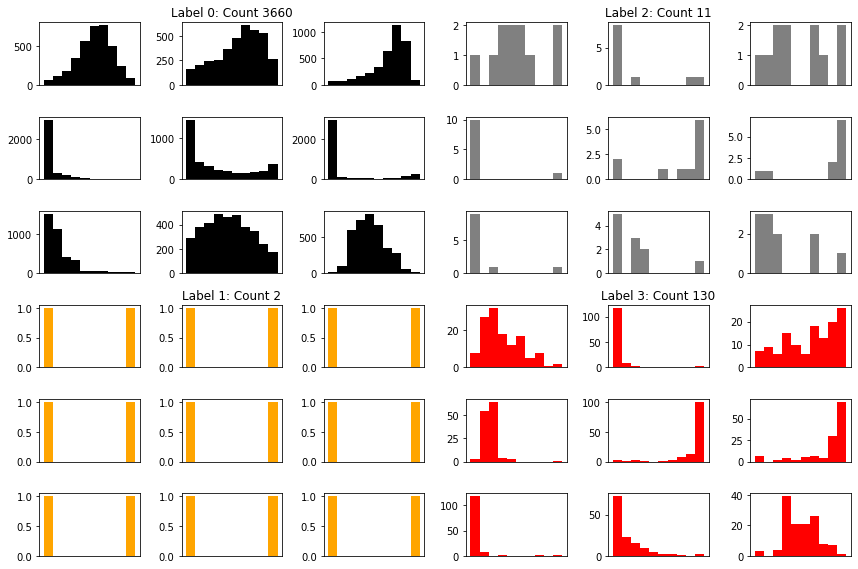

In [160]:
fig_graphs, fig_axes = plt.subplots(6,6, figsize=(12,8))
fig_graphs.tight_layout()

fig_axes[0,0].hist(analysis.loc[0]['danceability'], color='black');
fig_axes[0,1].hist(analysis.loc[0]['energy'], color='black');
fig_axes[0,1].set_title('Label 0: Count 3660');
fig_axes[0,2].hist(analysis.loc[0]['loudness'], color='black');
fig_axes[1,0].hist(analysis.loc[0]['speechiness'], color='black');
fig_axes[1,1].hist(analysis.loc[0]['acousticness'], color='black');
fig_axes[1,2].hist(analysis.loc[0]['instrumentalness'], color='black');
fig_axes[2,0].hist(analysis.loc[0]['liveness'], color='black');
fig_axes[2,1].hist(analysis.loc[0]['valence'], color='black');
fig_axes[2,2].hist(analysis.loc[0]['tempo'], color='black');

fig_axes[3,0].hist(analysis.loc[1]['danceability'], color='orange');
fig_axes[3,1].hist(analysis.loc[1]['energy'], color='orange');
fig_axes[3,1].set_title('Label 1: Count 2');
fig_axes[3,2].hist(analysis.loc[1]['loudness'], color='orange');
fig_axes[4,0].hist(analysis.loc[1]['speechiness'], color='orange');
fig_axes[4,1].hist(analysis.loc[1]['acousticness'], color='orange');
fig_axes[4,2].hist(analysis.loc[1]['instrumentalness'], color='orange');
fig_axes[5,0].hist(analysis.loc[1]['liveness'], color='orange');
fig_axes[5,1].hist(analysis.loc[1]['valence'], color='orange');
fig_axes[5,2].hist(analysis.loc[1]['tempo'], color='orange');

fig_axes[0,3].hist(analysis.loc[2]['danceability'], color='gray');
fig_axes[0,4].hist(analysis.loc[2]['energy'], color='gray');
fig_axes[0,4].set_title('Label 2: Count 11');
fig_axes[0,5].hist(analysis.loc[2]['loudness'], color='gray');
fig_axes[1,3].hist(analysis.loc[2]['speechiness'], color='gray');
fig_axes[1,4].hist(analysis.loc[2]['acousticness'], color='gray');
fig_axes[1,5].hist(analysis.loc[2]['instrumentalness'], color='gray');
fig_axes[2,3].hist(analysis.loc[2]['liveness'], color='gray');
fig_axes[2,4].hist(analysis.loc[2]['valence'], color='gray');
fig_axes[2,5].hist(analysis.loc[2]['tempo'], color='gray');

fig_axes[3,3].hist(analysis.loc[3]['danceability'], color='red');
fig_axes[3,4].hist(analysis.loc[3]['energy'], color='red');
fig_axes[3,4].set_title('Label 3: Count 130');
fig_axes[3,5].hist(analysis.loc[3]['loudness'], color='red');
fig_axes[4,3].hist(analysis.loc[3]['speechiness'], color='red');
fig_axes[4,4].hist(analysis.loc[3]['acousticness'], color='red');
fig_axes[4,5].hist(analysis.loc[3]['instrumentalness'], color='red');
fig_axes[5,3].hist(analysis.loc[3]['liveness'], color='red');
fig_axes[5,4].hist(analysis.loc[3]['valence'], color='red');
fig_axes[5,5].hist(analysis.loc[3]['tempo'], color='red');

for ax in fig_axes:
    for a in ax:
        a.set_xticks([])
        #a.set_yticks([])
    

#### Trying n_clusters = 5

Admittedly, the 4 clusters are extremely lopsided in size, and there are some clear outliers in the larger clusters. Let's see if this gets mitigated with 5

In [111]:
spectral_2 = SpectralClustering(n_clusters = 5)
new_labels = spectral_2.fit_predict(final_df)
pd.DataFrame({'labels': new_labels, 'counts': new_labels}).groupby('labels').count()

,counts
labels,
0,3389
1,2
2,11
3,49
4,352


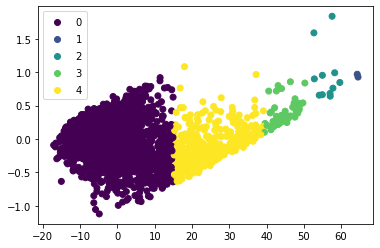

In [155]:
pca_2dN = pd.DataFrame(pca2d.fit_transform(final_df))
pca_2dN['labels'] = new_labels
pca_2dN.columns = ['x','y','labels']
scat_5c = plt.scatter(pca_2dN['x'], pca_2dN['y'], c=pca_2dN['labels']);
plt.legend(*scat_5c.legend_elements());

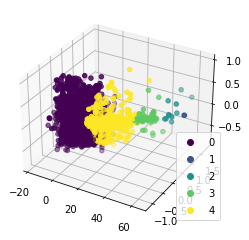

In [158]:
pca_3dN = pd.DataFrame(pca3d.fit_transform(final_df))
pca_3dN['labels'] = new_labels
pca_3dN.columns = ['x','y','z','labels']

ax = plt.axes(projection='3d')
scat_5c3d = ax.scatter3D(pca_3dN['x'], pca_3dN['y'], pca_3dN['z'], c=pca_3dN['labels']);
plt.legend(*scat_5c3d.legend_elements(), loc="lower right");

In [128]:
analysis_n = main_df.T.apply(pd.to_numeric, errors='coerce').dropna().T.\
    drop(columns=['msPlayed', 'time_signature', 'mode', 'duration_ms', 'key']).drop_duplicates()
analysis_n['label'] = new_labels
analysis_n = analysis_n.sort_values(by=['label']).set_index('label')
analysis_n

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
label,,,,,,,,,
0,0.519,0.9000,-4.844,0.0490,0.0126,0.000055,0.1030,0.5940,120.001
0,0.330,0.4690,-9.286,0.0335,0.3100,0.000002,0.0402,0.4330,201.327
0,0.514,0.3190,-15.403,0.0583,0.9300,0.900000,0.1040,0.3270,107.969
0,0.682,0.4440,-7.689,0.0289,0.2570,0.000000,0.1150,0.9100,130.704
0,0.824,0.0816,-15.760,0.0717,0.9670,0.889000,0.1050,0.5620,140.067
...,...,...,...,...,...,...,...,...,...
4,0.383,0.1480,-21.072,0.0459,0.9750,0.811000,0.2750,0.1370,107.990
4,0.571,0.0274,-20.274,0.0649,0.9480,0.000006,0.3220,0.0870,124.209
4,0.573,0.1010,-17.446,0.0594,0.9930,0.926000,0.1120,0.0895,97.361


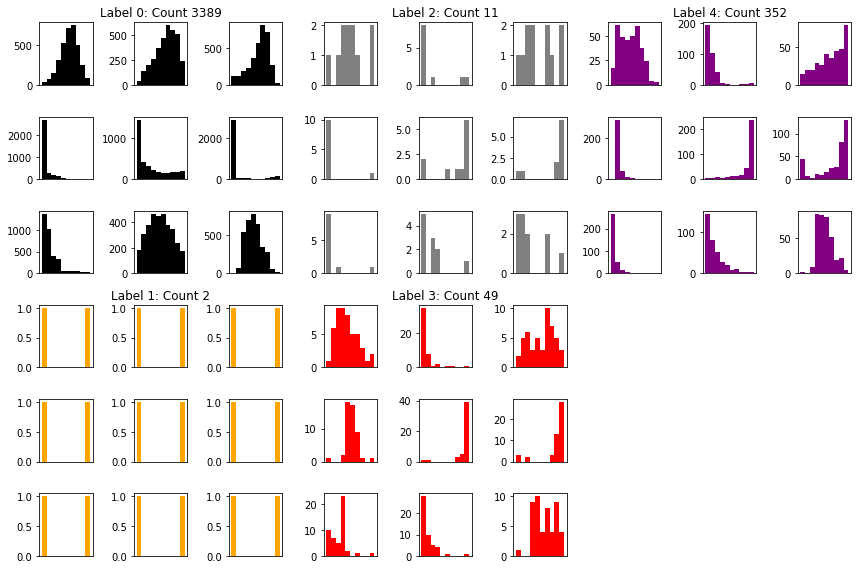

In [147]:
fig_graphs, fig_axes = plt.subplots(6,9, figsize=(12,8))
fig_graphs.tight_layout()

fig_axes[0,0].hist(analysis_n.loc[0]['danceability'], color='black');
fig_axes[0,1].hist(analysis_n.loc[0]['energy'], color='black');
fig_axes[0,1].set_title('Label 0: Count 3389');
fig_axes[0,2].hist(analysis_n.loc[0]['loudness'], color='black');
fig_axes[1,0].hist(analysis_n.loc[0]['speechiness'], color='black');
fig_axes[1,1].hist(analysis_n.loc[0]['acousticness'], color='black');
fig_axes[1,2].hist(analysis_n.loc[0]['instrumentalness'], color='black');
fig_axes[2,0].hist(analysis_n.loc[0]['liveness'], color='black');
fig_axes[2,1].hist(analysis_n.loc[0]['valence'], color='black');
fig_axes[2,2].hist(analysis_n.loc[0]['tempo'], color='black');

fig_axes[3,0].hist(analysis_n.loc[1]['danceability'], color='orange');
fig_axes[3,1].hist(analysis_n.loc[1]['energy'], color='orange');
fig_axes[3,1].set_title('Label 1: Count 2');
fig_axes[3,2].hist(analysis_n.loc[1]['loudness'], color='orange');
fig_axes[4,0].hist(analysis_n.loc[1]['speechiness'], color='orange');
fig_axes[4,1].hist(analysis_n.loc[1]['acousticness'], color='orange');
fig_axes[4,2].hist(analysis_n.loc[1]['instrumentalness'], color='orange');
fig_axes[5,0].hist(analysis_n.loc[1]['liveness'], color='orange');
fig_axes[5,1].hist(analysis_n.loc[1]['valence'], color='orange');
fig_axes[5,2].hist(analysis_n.loc[1]['tempo'], color='orange');

fig_axes[0,3].hist(analysis_n.loc[2]['danceability'], color='gray');
fig_axes[0,4].hist(analysis_n.loc[2]['energy'], color='gray');
fig_axes[0,4].set_title('Label 2: Count 11');
fig_axes[0,5].hist(analysis_n.loc[2]['loudness'], color='gray');
fig_axes[1,3].hist(analysis_n.loc[2]['speechiness'], color='gray');
fig_axes[1,4].hist(analysis_n.loc[2]['acousticness'], color='gray');
fig_axes[1,5].hist(analysis_n.loc[2]['instrumentalness'], color='gray');
fig_axes[2,3].hist(analysis_n.loc[2]['liveness'], color='gray');
fig_axes[2,4].hist(analysis_n.loc[2]['valence'], color='gray');
fig_axes[2,5].hist(analysis_n.loc[2]['tempo'], color='gray');

fig_axes[3,3].hist(analysis_n.loc[3]['danceability'], color='red');
fig_axes[3,4].hist(analysis_n.loc[3]['energy'], color='red');
fig_axes[3,4].set_title('Label 3: Count 49');
fig_axes[3,5].hist(analysis_n.loc[3]['loudness'], color='red');
fig_axes[4,3].hist(analysis_n.loc[3]['speechiness'], color='red');
fig_axes[4,4].hist(analysis_n.loc[3]['acousticness'], color='red');
fig_axes[4,5].hist(analysis_n.loc[3]['instrumentalness'], color='red');
fig_axes[5,3].hist(analysis_n.loc[3]['liveness'], color='red');
fig_axes[5,4].hist(analysis_n.loc[3]['valence'], color='red');
fig_axes[5,5].hist(analysis_n.loc[3]['tempo'], color='red');

fig_axes[0,6].hist(analysis_n.loc[4]['danceability'], color='purple');
fig_axes[0,7].hist(analysis_n.loc[4]['energy'], color='purple');
fig_axes[0,7].set_title('Label 4: Count 352');
fig_axes[0,8].hist(analysis_n.loc[4]['loudness'], color='purple');
fig_axes[1,6].hist(analysis_n.loc[4]['speechiness'], color='purple');
fig_axes[1,7].hist(analysis_n.loc[4]['acousticness'], color='purple');
fig_axes[1,8].hist(analysis_n.loc[4]['instrumentalness'], color='purple');
fig_axes[2,6].hist(analysis_n.loc[4]['liveness'], color='purple');
fig_axes[2,7].hist(analysis_n.loc[4]['valence'], color='purple');
fig_axes[2,8].hist(analysis_n.loc[4]['tempo'], color='purple');

fig_axes[3,6].axis('off')
fig_axes[3,7].axis('off')
fig_axes[3,8].axis('off')
fig_axes[4,6].axis('off')
fig_axes[4,7].axis('off')
fig_axes[4,8].axis('off')
fig_axes[5,6].axis('off')
fig_axes[5,7].axis('off')
fig_axes[5,8].axis('off')

for ax in fig_axes:
    for a in ax:
        a.set_xticks([])
        #a.set_yticks([])
    

Outliers are still present in some, but overall I would say it is better distributed (further shown by the 3D graph)